In [ ]:
# Classification and Sequence Labelling - Task 2

In [ ]:
# Loads Data

In [1]:
# Loads data using code from activity recognition
import os

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [3]:
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

In [4]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

In [5]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

In [6]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [7]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

In [8]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

In [9]:
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

In [ ]:
# End of standard data loading code

In [ ]:
# Task 3a - Creates a HMM for sequence labelling

In [10]:
import nltk
from nltk.corpus import brown
from nltk.probability import ConditionalFreqDist,ConditionalProbDist,MLEProbDist
import itertools

In [12]:
# Defines the transistion model
# Creates a chain of tuples (y_t, y_t+1)
tag_pairs=(((y[i], y[i+1]) for i in range(len(y) - 1)) for y in y_by_seq_tr)
# Defines transition probability
transition_f = ConditionalFreqDist(itertools.chain.from_iterable(tag_pairs))
transition_p = ConditionalProbDist(transition_f, probdist_factory=MLEProbDist)
# Creates transition matrix
trans_matrix = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        trans_matrix[i, j] = transition_p[i].prob(j)

In [13]:
# Calculates starting state probabilities based on training data
start_probs = np.zeros(n_states)
for y in y_by_seq_tr:
    start_probs[y[0]] += 1
start_probs = start_probs / len(y_by_seq_tr)

In [14]:
# Creates HMM model
model = hmm.GaussianHMM(covariance_type='diag', n_components=n_states)
model.startprob_ = start_probs
model.transmat_ = trans_matrix
model.means_ = means
model.covars_ = diagonal_covars
model.init_params = ''

In [15]:
# Evaluates HMM model
no_states = 0
no_correct = 0
for idx in range(len(X_by_seq_test)):
    # Uses viterbi to decode likely actual state sequence
    _, y_pred = model.decode(X_by_seq_test[idx])
    # Meausres number of correct states
    no_correct_in_seq = 0
    for y_idx in range(len(y_pred)):
        no_states += 1
        if y_pred[y_idx] == (y_by_seq_test[idx])[y_idx]: no_correct_in_seq += 1
    print("Seq acc", no_correct_in_seq / len(y_pred))
    no_correct += no_correct_in_seq
acc = no_correct / no_states
print("Accuracy", acc)

Seq acc 1.0
Seq acc 0.9023058252427184
Seq acc 0.8295454545454546
Seq acc 1.0
Seq acc 0.8932926829268293
Seq acc 1.0
Seq acc 0.9506172839506173
Seq acc 0.8478260869565217
Seq acc 0.6571428571428571
Seq acc 0.8298291721419185
Seq acc 1.0
Seq acc 1.0
Accuracy 0.8679055750878956


[[0.991 0.    0.005 0.004]
 [0.    0.989 0.001 0.01 ]
 [0.002 0.    0.997 0.001]
 [0.027 0.025 0.006 0.943]]


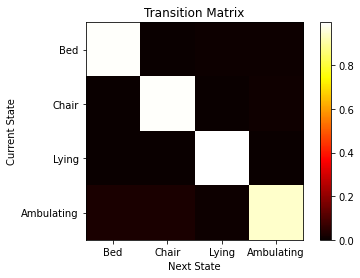

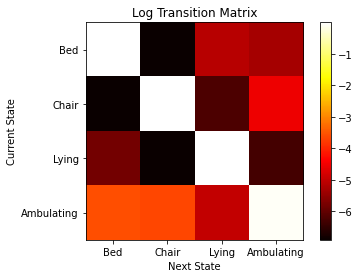

In [16]:
# Task 3b - Plots transition matrix
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(trans_matrix)
plt.imshow(trans_matrix, cmap='hot', interpolation='nearest')
plt.title("Transition Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.xticks(np.arange(0, 4), ["Bed", "Chair", "Lying", "Ambulating"])
plt.yticks(np.arange(0, 4), ["Bed", "Chair", "Lying", "Ambulating"])
plt.colorbar()
plt.show()
plt.imshow(np.log(trans_matrix + 0.001), cmap='hot', interpolation='nearest')
plt.title("Log Transition Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.colorbar()
plt.xticks(np.arange(0, 4), ["Bed", "Chair", "Lying", "Ambulating"])
plt.yticks(np.arange(0, 4), ["Bed", "Chair", "Lying", "Ambulating"])
plt.show()

In [17]:
# Task 3c
states=  ["Bed", "Chair", "Lying", "Ambulating"]
for i in range(n_states):
    print("*****************************************")
    print(states[i], "mean")
    print(input_cols)
    print(means[i])
print("------------------------------------")
print("------------------------------------")
for i in range(n_states):
    print("*****************************************")
    print(states[i], "vars/covars")
    print(input_cols)
    print(diagonal_covars[i])

*****************************************
Bed mean
['frontal acc', 'vertical acc', 'lateral acc', 'RSSI', 'phase', 'frequency']
[  0.357   0.934   0.057 -58.992   3.157 922.743]
*****************************************
Chair mean
['frontal acc', 'vertical acc', 'lateral acc', 'RSSI', 'phase', 'frequency']
[  0.551   0.866   0.067 -58.165   3.489 922.654]
*****************************************
Lying mean
['frontal acc', 'vertical acc', 'lateral acc', 'RSSI', 'phase', 'frequency']
[  1.092   0.001  -0.027 -58.424   3.322 922.8  ]
*****************************************
Ambulating mean
['frontal acc', 'vertical acc', 'lateral acc', 'RSSI', 'phase', 'frequency']
[  0.223   0.965   0.023 -54.19    3.148 922.885]
------------------------------------
------------------------------------
*****************************************
Bed vars/covars
['frontal acc', 'vertical acc', 'lateral acc', 'RSSI', 'phase', 'frequency']
[0.047 0.01  0.013 8.062 5.03  2.84 ]
******************************

In [19]:
# Task 3c. Measures training time.
# Training is extremely quick. However, I will define training time as the time
# taken to calculate all of the HMM_params given X_by_seq_train and Y_by_seq_train.
import time
no_repitions = 100
mean_time = 0
for rep in range(no_repitions):
    start_time = time.time()
    # Contains repeated data loading and model creation code from earlier in notebook
    n_states = max(np.unique(np.concatenate(y_by_seq_tr)).size, np.unique(np.concatenate(y_by_seq_test)).size)
    # Record which observations occur given each state (activity label)
    X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label
    
    for s, X_seq in enumerate(X_by_seq_tr):
        for i in range(X_seq.shape[0]):
            state_i = y_by_seq_tr[s][i]
            X_given_y[state_i].append(X_seq[i, :][None, :])
    # Defines the transistion model
    # Creates a chain of tuples (y_t, y_t+1)
    tag_pairs=(((y[i], y[i+1]) for i in range(len(y) - 1)) for y in y_by_seq_tr)
    # Defines transition probability
    transition_f = ConditionalFreqDist(itertools.chain.from_iterable(tag_pairs))
    transition_p = ConditionalProbDist(transition_f, probdist_factory=MLEProbDist)
    # Creates transition matrix
    trans_matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            trans_matrix[i, j] = transition_p[i].prob(j)
    # Calculates starting state probabilities based on training data
    start_probs = np.zeros(n_states)
    for y in y_by_seq_tr:
        start_probs[y[0]] += 1
    start_probs = start_probs / len(y_by_seq_tr)
    # Creates HMM model
    model = hmm.GaussianHMM(covariance_type='diag', n_components=n_states)
    model.startprob_ = start_probs
    model.transmat_ = trans_matrix
    model.means_ = means
    model.covars_ = diagonal_covars
    model.init_params = ''
    mean_time += time.time() - start_time
mean_time /= no_repitions
print("Time taken to train", mean_time, "seconds")

Time taken to train 0.054920456409454345 seconds


In [20]:
# Code below used to plot a transition matrix. Code has been taken from
#https://github.com/NaysanSaran/markov-chain/tree/master.
# Credit to Naysan Saran and M Shaf Khattak.
# Code license allows me to use code.
# For CW purposes, this should be treated as a library import

In [21]:
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

class Node():

    def __init__(
        self, center, radius, label,
        facecolor='#2653de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3',
        **kwargs
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]

        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor

        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.03

        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': kwargs.get("node_fontsize", 12)
        }


    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle],
            edgecolor = self.node_edgecolor,
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label,
            xy = self.center,
            color = '#ffffff',
            **self.text_args
        )


    def add_self_loop(self, ax, prob=None, direction='up', annotate = True, percentages = False):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15

        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y),
            self.radius,
            start,
            angle,
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow],
            edgecolor = self.ring_edgecolor,
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        if prob and annotate:
            text = f"{prob*100 if percentages else prob:.4f}".rstrip("0").rstrip(".")
            text += "%" if percentages else ""
            ax.annotate(text, xy=(self.x, prob_y), color='#000000', **self.text_args)

In [22]:
# Attempts to draw transition matrix as a directed graph
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# module from this repository
class MarkovChain:

    def __init__(self, M, labels, **kwargs):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
            - kwargs    Keywords to modify how data is displayed, specifically:
                        annotate          if False, probabilities aren't shown
                        arrow_edgecolor
                        arrow_facecolor
                        arrow_head_width
                        arrow_width
                        fontsize          affects transition probability labels
                        node_edgecolor
                        node_facecolor
                        node_fontsize     affects node labels
                        node_radius
                        percentages       bool, if True probabilites should be
                                          displayed as percentages instead of decimals
                        transparency_func function to determine transparency of arrows (default: alpha = prob)
        """

        np.set_printoptions(precision=3,suppress=True)



        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        # save args
        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        self.save_kwargs(**kwargs)



        # Build the network
        self.build_network()

    def save_kwargs(self, **kwargs):

        # save the dictionary
        self.kwargs = kwargs

        # Colors
        self.arrow_facecolor = self.kwargs.get("arrow_facecolor", '#a3a3a3')
        self.arrow_edgecolor = self.kwargs.get("arrow_edgecolor", '#a3a3a3')
        self.node_facecolor = self.kwargs.get("node_facecolor", '#2693de')
        self.node_edgecolor = self.kwargs.get("node_edgecolor", '#e6e6e6')

        # Drawing config
        self.node_radius = self.kwargs.get("node_radius", 0.60)
        self.arrow_width = self.kwargs.get("arrow_width", 0.1)
        self.arrow_head_width = self.kwargs.get("arrow_head_width", 0.22)
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': self.kwargs.get("fontsize", 14)
        }

        # How to represent the probabilities
        self.percentages = self.kwargs.get("percentages", False)
        self.annotate_probabilities = self.kwargs.get("annotate", True)
        self.transparency_func = self.kwargs.get("transparency_func", lambda p: p)


    def set_node_centers(self):
        """
            Spread the nodes evenly around in a circle using Euler's formula
            e^(2pi*i*k/n), where n is the number of nodes and k is the
            index over which we iterate. The real part is the x coordinate,
            the imaginary part is the y coordinate. Then scale by n for more room.

            self.node_centers is a numpy array of shape (n,2)
        """

        # For legibility, we use n below
        n = self.n_states

        # generate the evenly spaced coords on the unit circle
        unit_circle_coords = np.fromfunction(lambda x,y:
                        (1-y)*np.real(np.exp(2 * np.pi * x/n * 1j))
                        + y * np.imag(np.exp(2 * np.pi * x/n * 1j)),
                        (n,2))

        self.figsize = (n*2+2, n*2+2)
        self.xlim = (-n-1, n+1)
        self.ylim = (-n-1, n+1)

        # Scale by n to have more room
        self.node_centers = unit_circle_coords * n


    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = [Node(self.node_centers[i],
                           self.node_radius,
                           self.labels[i],
                           **self.kwargs) for i in range(self.n_states)]


    def add_arrow(self, ax,
                  node1, node2,
                  prob=None, width=None,
                  head_width=None,
                  annotate = True,
                  arrow_spacing = 0.15,
                  transparency_func = None):
        """
        Add a directed arrow between two nodes

        Keywords:

        annotate:                if True, probability is displayed on top of the arrow
        arrow_spacing:           determines space between arrows in opposite directions
        head_width:              width of arrow head
        prob:                    probability of going from node1 to node2
        transparency_func:       function to determine transparency of arrows
        width:                   width of arrow body
        """


        if width is None:
            width = self.arrow_width
        if head_width is None:
            head_width = self.arrow_head_width
        if transparency_func is None:
            transparency_func = self.transparency_func

        # x,y start of the arrow, just touching the starting node
        x_start = node1.x + node1.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        y_start = node1.y + node1.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # find the arrow length so it just touches the ending node
        dx = node2.x-x_start - node2.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        dy = node2.y-y_start - node2.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)


        # calculate offset so arrows in opposite directions are separate

        x_offset = dy / np.sqrt(dx**2+dy**2) * arrow_spacing
        y_offset = -dx / np.sqrt(dx**2+dy**2) * arrow_spacing

        arrow = mpatches.FancyArrow(
            x_start + x_offset,
            y_start + y_offset,
            dx,
            dy,
            width = width,
            head_width = head_width,
            length_includes_head = True
        )
        p = PatchCollection(
            [arrow],
            edgecolor = self.arrow_edgecolor,
            facecolor = self.arrow_facecolor,
            alpha = max(transparency_func(prob), 0.1)
        )
        ax.add_collection(p)

        # Add label of probability at coordinates (x_prob, y_prob)
        x_prob = x_start +  0.2*dx + 1.2 * x_offset
        y_prob = y_start +  0.2*dy + 1.2 * y_offset
        if prob and annotate:
            text = f"{prob*100 if self.percentages else prob:.4f}".rstrip("0").rstrip(".")
            text += "%" if self.percentages else ""
            ax.annotate(text, xy=(x_prob, y_prob), color='#000000', **self.text_args)


    def draw(self, img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)

        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if i == j and self.M[i,i] > 0:
                    self.nodes[i].add_self_loop(ax,
                                                prob = self.M[i,j],
                                                direction = 'up' if self.nodes[i].y >= 0 else 'down',
                                                annotate = self.annotate_probabilities,
                                                percentages = self.percentages)

                # directed arrows
                elif self.M[i,j] > 0:
                    self.add_arrow(ax,
                                   self.nodes[i],
                                   self.nodes[j],
                                   prob = self.M[i,j],
                                   annotate = self.annotate_probabilities)

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()

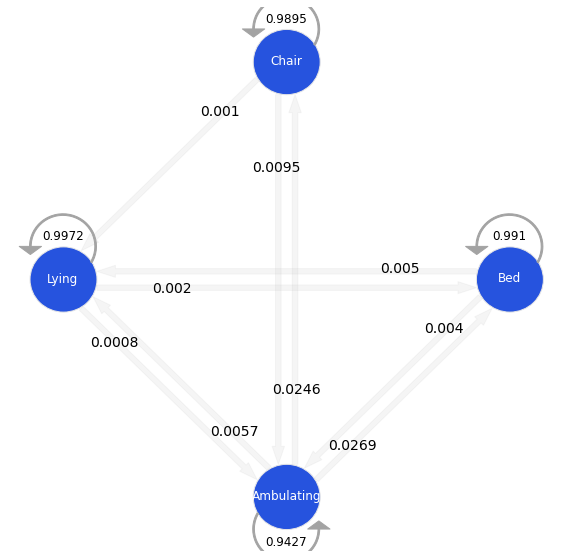

In [23]:
mc = MarkovChain(trans_matrix, ['Bed', 'Chair', 'Lying', 'Ambulating'])
mc.draw("trans_mat.png")

In [ ]:
 # End of code taken from https://github.com/NaysanSaran/markov-chain/tree/master